## Goal of the project: 
Find out factors that affects the overall satisfaction of airline passengers to better reallocate resources to make customers happy.

## Workflow:
1. Audit and clean the data
2. Use visualization to find out potential factors that could affect the possibility of airline passengers' being happy.
3. Test the significance of those factors in a logistic regression
4. Build a ML algorithm to predict if a customer is satisfied

This notebook will achieve the first two part of the workflow

### Import my toolkit

In [1]:
import os
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import time
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import sklearn
from collections import Counter
from scipy.stats import kruskal, pearsonr, spearmanr, chi2_contingency, f_oneway
from scipy.stats import kurtosis, skew, probplot, boxcox, boxcox_normplot
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.decomposition import NMF, LatentDirichletAllocation
from scipy.stats import pearsonr,spearmanr,gaussian_kde
from nltk.stem import WordNetLemmatizer
import re
from datetime import timedelta 

### Import dataset

In [2]:
df=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

### Data Auditing

In [3]:
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
# It seems like that the first column is just an index, which is redundant, so we drop it
df=df.iloc[:,1:]
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [5]:
# View the columns and missing values of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 24 columns):
id                                   103904 non-null int64
Gender                               103904 non-null object
Customer Type                        103904 non-null object
Age                                  103904 non-null int64
Type of Travel                       103904 non-null object
Class                                103904 non-null object
Flight Distance                      103904 non-null int64
Inflight wifi service                103904 non-null int64
Departure/Arrival time convenient    103904 non-null int64
Ease of Online booking               103904 non-null int64
Gate location                        103904 non-null int64
Food and drink                       103904 non-null int64
Online boarding                      103904 non-null int64
Seat comfort                         103904 non-null int64
Inflight entertainment               103904 non-null int64


In [6]:
# Since the missing values are few, we will drop the corresponding rows
df=df[df['Arrival Delay in Minutes'].notnull()]

In [7]:
# Summary statistics
df.describe().round()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0,103594.0
mean,64942.0,39.0,1189.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,15.0,15.0
std,37461.0,15.0,997.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,38.0,39.0
min,1.0,7.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
25%,32562.0,27.0,414.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,2.0,0.0,0.0
50%,64890.0,40.0,842.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,0.0,0.0
75%,97370.0,51.0,1743.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,4.0,12.0,13.0
max,129880.0,85.0,4983.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1592.0,1584.0


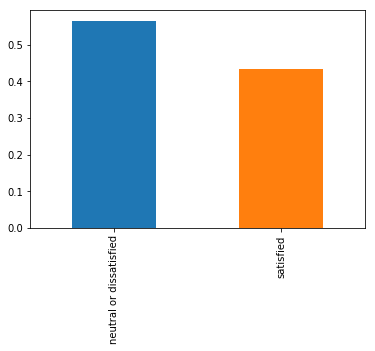

In [8]:
# Check the distribution of the target
df.satisfaction.value_counts(normalize = True).plot(kind='bar')
plt.show()

### 2. Identify potential factors that have association with customer satisfaction

#### 2.1 Age

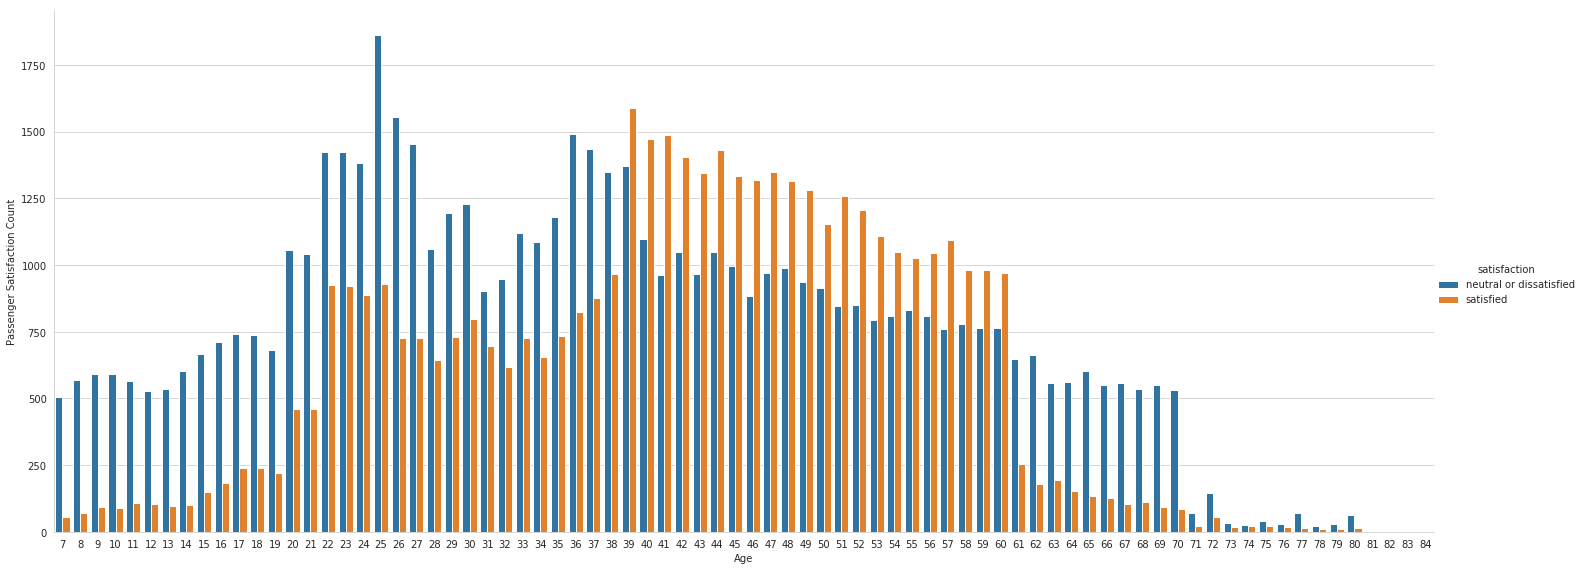

In [9]:
# Check for age
with sns.axes_style('whitegrid'):
    g = sns.catplot("Age", data=df, height=8, aspect=2.5, kind='count', hue='satisfaction', order=range(df['Age'].min(), df['Age'].max()))
    g.set_ylabels('Passenger Satisfaction Count')

The graph shows that Customers aged below 22 and above 61 are "difficult customers" who are more likely to be neutral or dissatisfied. Customers aged between 23 and 38 are normal customers in terms of satisfaction. Customers aged between 39 and 60 are relatively satisfied.

#### 2.2 Class, gender, loyalty, and travel type

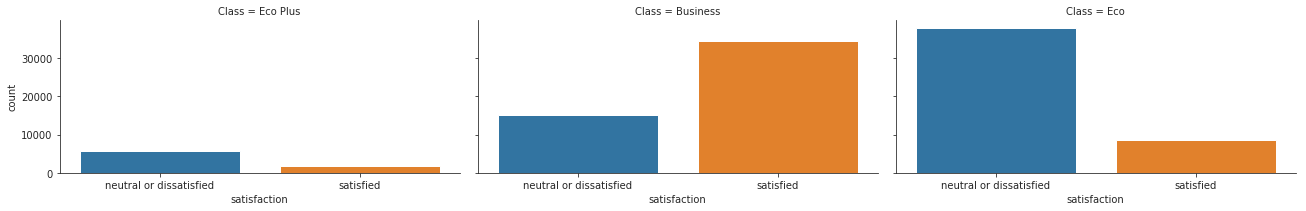

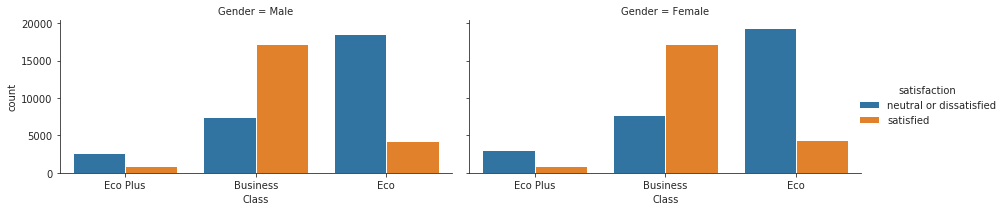

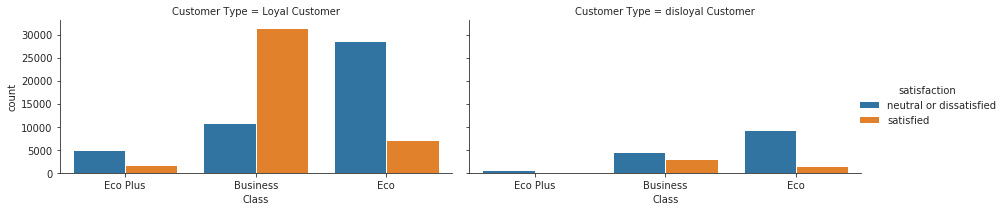

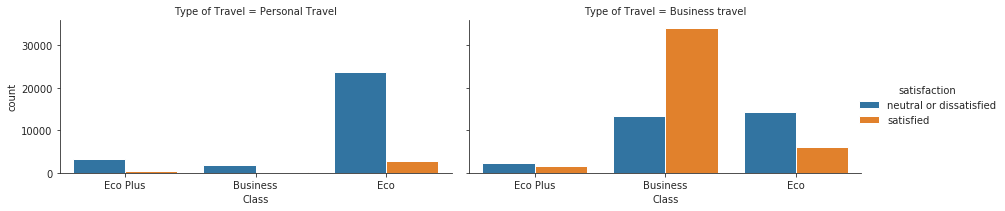

In [10]:
# Check for gender, loyalty, and class
with sns.axes_style(style='ticks'):
    g = sns.catplot("satisfaction", col="Class", data=df, kind="count", height=3, aspect=2)
    g = sns.catplot("Class", col="Gender",hue='satisfaction', data=df, kind="count", height=3, aspect=2)  
    g = sns.catplot("Class", col="Customer Type",hue='satisfaction', data=df, kind="count", height=3, aspect=2)
    g = sns.catplot("Class", col="Type of Travel",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

From the graph, we can see that:
1. Gender does not seem to distinguish satisfied customers
2. Loyal Customers seem to be more likely to be satisfied
3. Most Happy customers are from the Business Class
4. Business Traveller are more likely to be happy

#### 2.3 Flight distance and delay

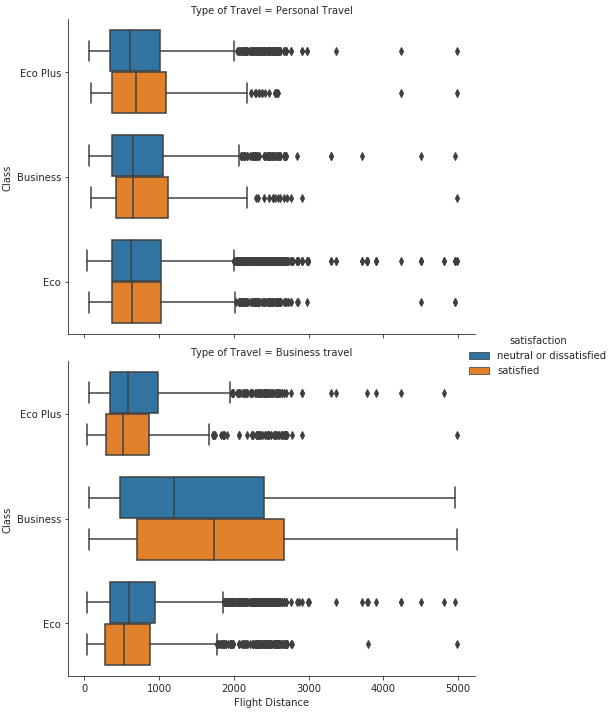

In [11]:
# Next, let's check for flight distance, departure delay, and arrival delay.
with sns.axes_style(style='ticks'):
    g = sns.catplot(x="Flight Distance", y="Class",hue="satisfaction",row='Type of Travel',
                kind="box", orient="h", height=5, aspect=1.4,
                data=df)

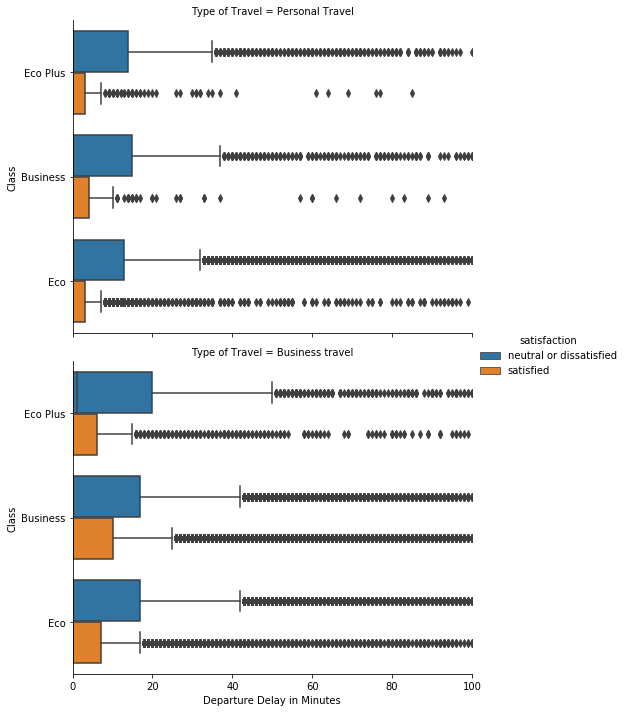

In [12]:
g = sns.catplot(x="Departure Delay in Minutes", y="Class",hue="satisfaction",row='Type of Travel',
                kind="box", orient="h", height=5, aspect=1.4,
                data=df)
g.set(xlim=(0,100))

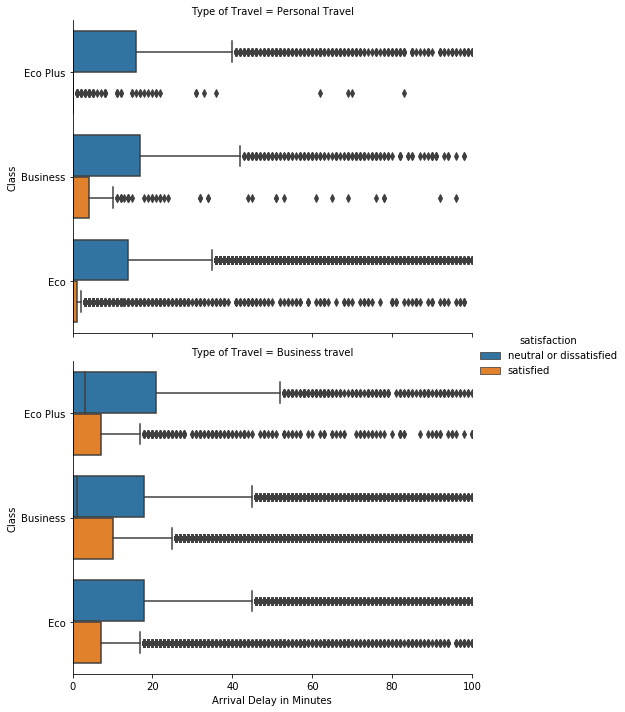

In [13]:
g = sns.catplot(x="Arrival Delay in Minutes", y="Class",hue="satisfaction",row='Type of Travel',
                kind="box", orient="h", height=5, aspect=1.4,
                data=df)
g.set(xlim=(0,100))

Findings from the graphs:

1. For personal passengers, flight distance seem to have no association with satisfaction

2. For business passengers, flight distance seems to associate with a negative impact on satisfaction level if not business class; but satisfied passengers seem to enjoy long flight if they are at business class

3. Both arrival delay and departure delay negatively associate with satisfaction level

#### 2.4 Survey rating scales

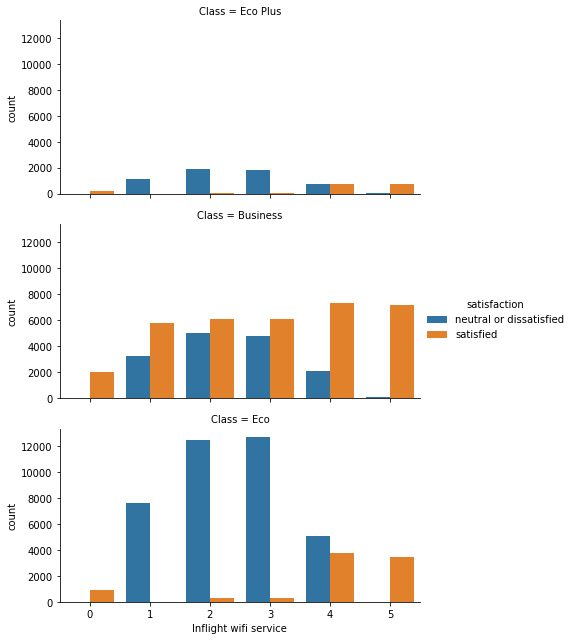

In [14]:
# Inflight wifi service
g = sns.catplot("Inflight wifi service", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

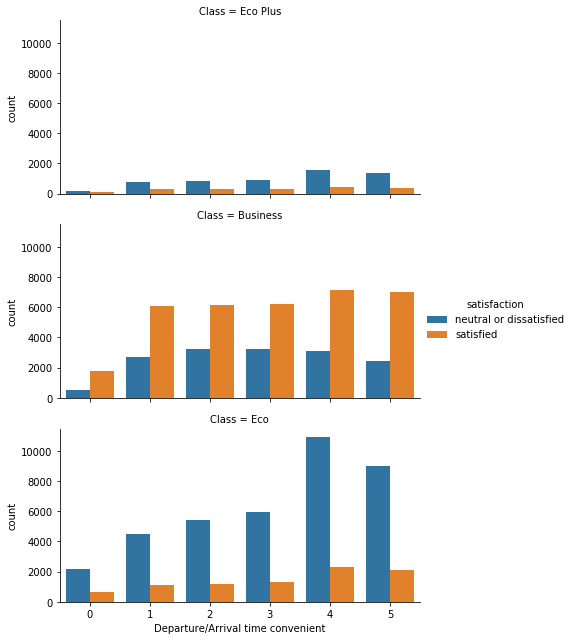

In [15]:
# Arrival departure convenience
g = sns.catplot("Departure/Arrival time convenient", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

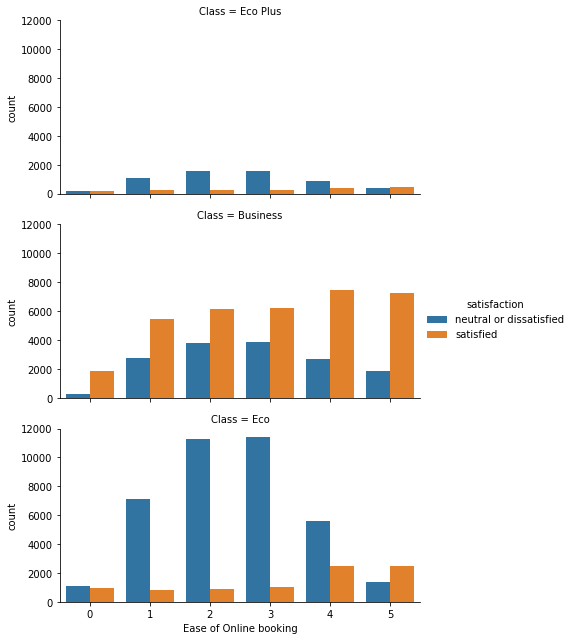

In [16]:
# Ease of Online Booking
g = sns.catplot("Ease of Online booking", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

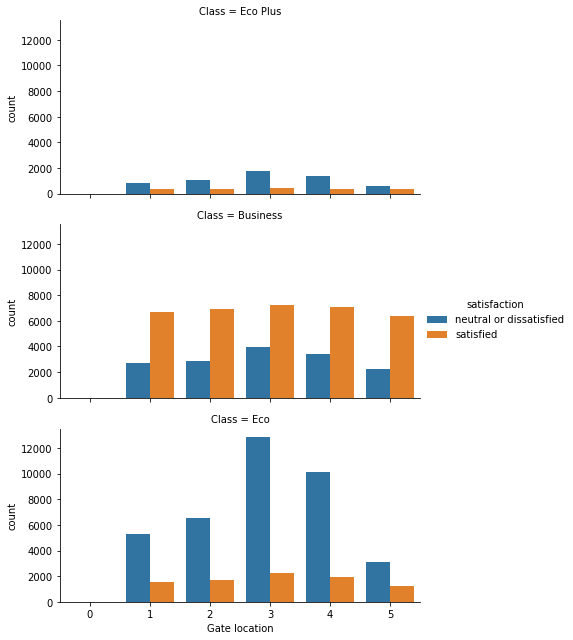

In [17]:
# Gate location
g = sns.catplot("Gate location", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

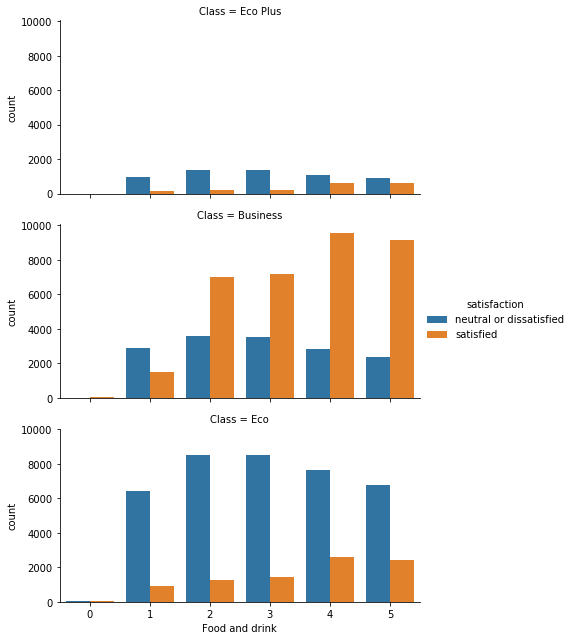

In [18]:
# Food and drink
g = sns.catplot("Food and drink", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

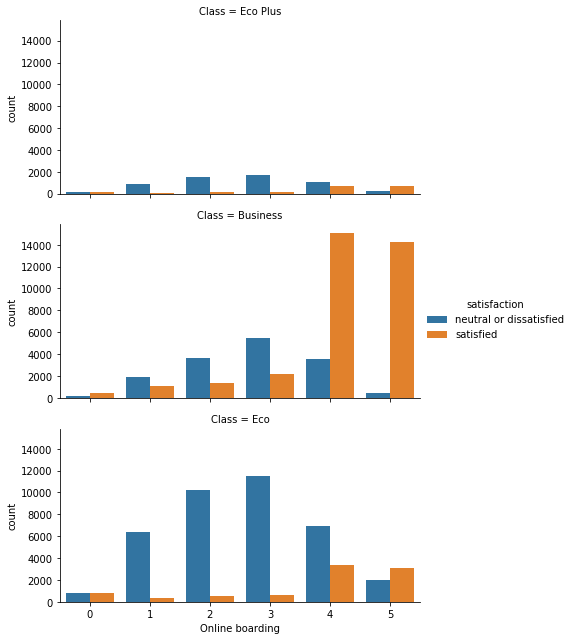

In [19]:
# Online boarding
g = sns.catplot("Online boarding", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

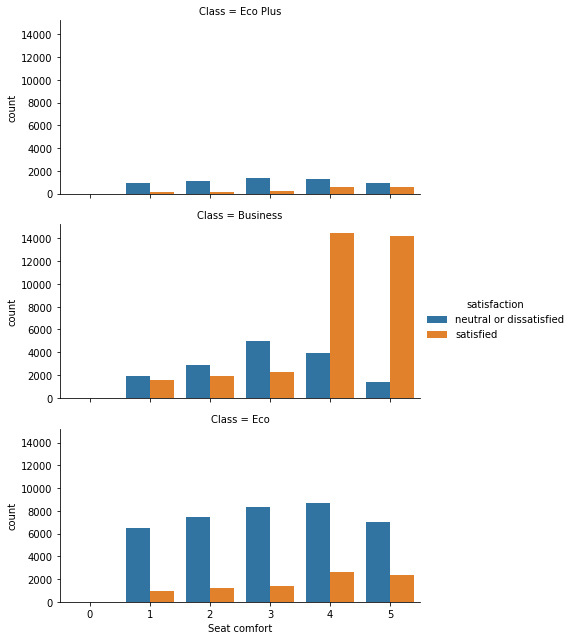

In [20]:
# Seat comfort
g = sns.catplot("Seat comfort", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

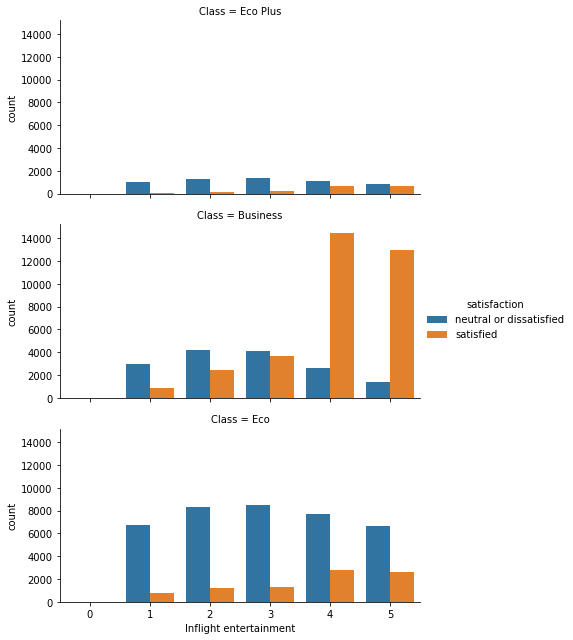

In [21]:
# Inflight entertainment
g = sns.catplot("Inflight entertainment", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

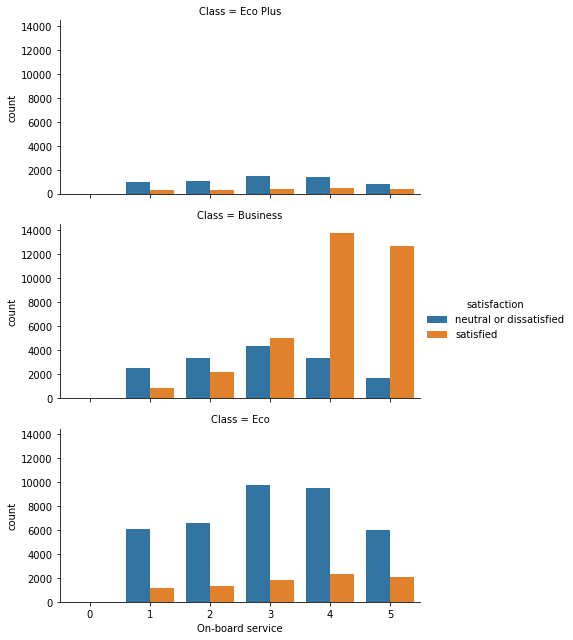

In [22]:
# On-board service
g = sns.catplot("On-board service", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

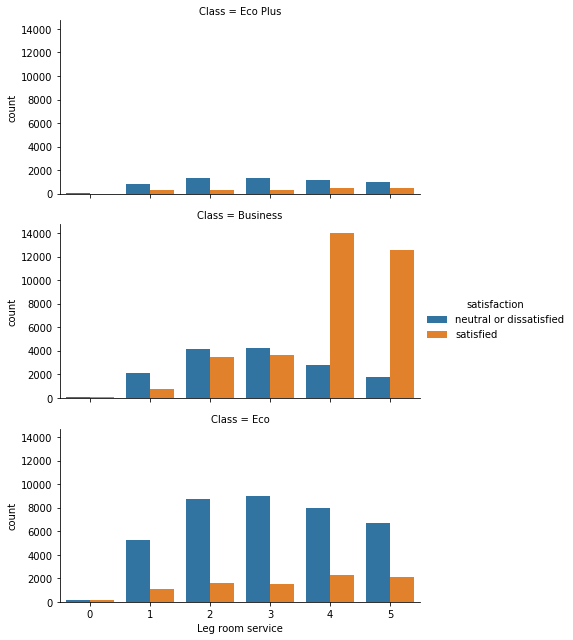

In [23]:
# Leg room service
g = sns.catplot("Leg room service", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

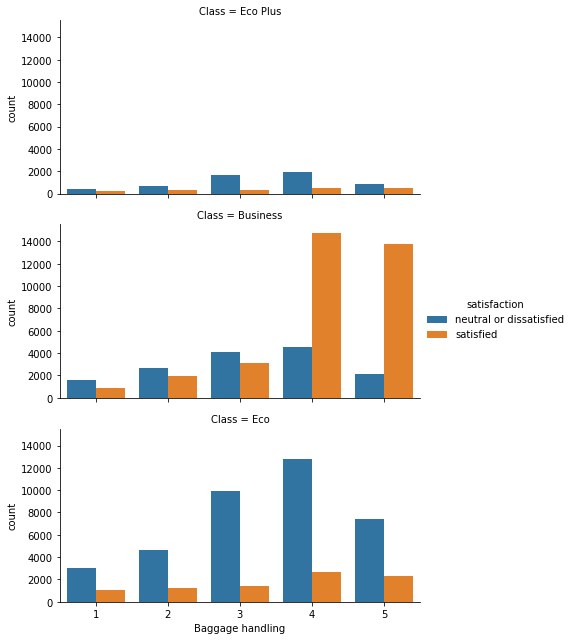

In [24]:
# Baggage handling
g = sns.catplot("Baggage handling", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

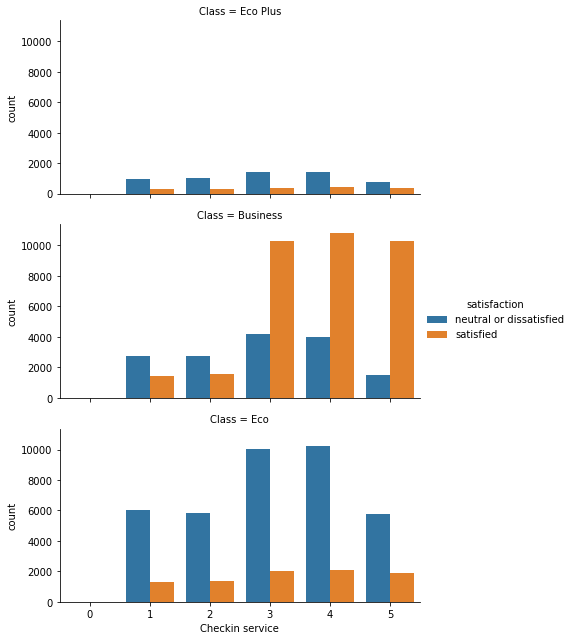

In [25]:
# Checkin service
g = sns.catplot("Checkin service", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

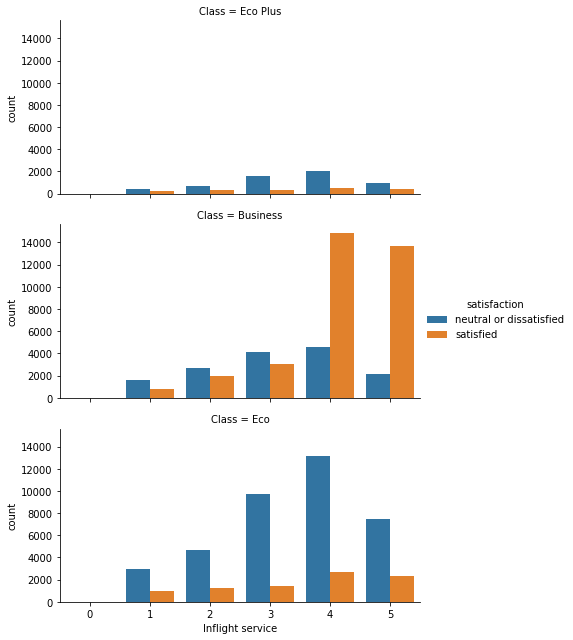

In [26]:
# Inflight service
g = sns.catplot("Inflight service", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

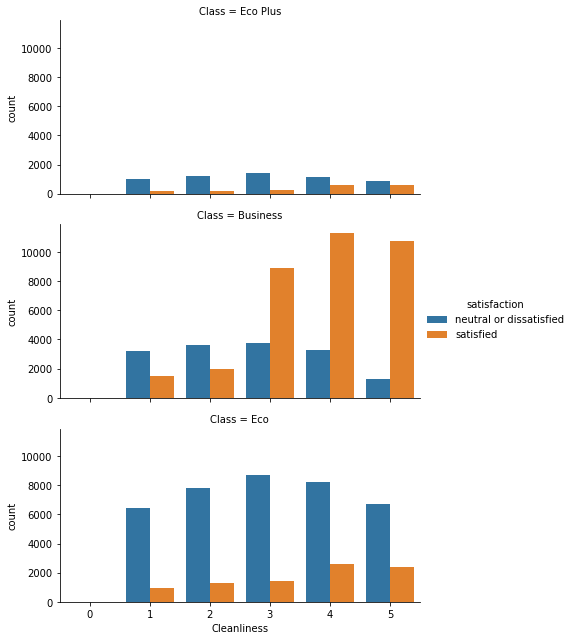

In [27]:
# Cleanliness
g = sns.catplot("Cleanliness", row="Class",hue='satisfaction', data=df, kind="count", height=3, aspect=2)

Almost high scores of all items associate with higher satisfaction level, except for departure/arrival time convenience.

Among all the items, these associate more with higher satisfaction level of business class passengers than other classes:

1 Seat comfort
2 On-board service
3 Leg room service
4 Baggages handling
5 Checkin service

## Summary of findings

1. For personal passengers, flight distance seem to have no association with satisfaction.


2. For business passengers, flight distance seems to associate with a negative impact on satisfaction level if not business class; but satisfied passengers seem to enjoy long flight if they are at business class.


3. Both arrival delay and departure delay negatively associate with satisfaction level.


4. Gender does not seem to distinguish satisfied customers.


5. Loyal Customers seem to be more likely to be satisfied.


6. Most Happy customers are from the Business Class.


7. Business Traveller are more likely to be satisfied.


8. Almost high scores of all items associate with higher satisfaction level, except for departure/arrival time convenience.


9. The graph shows that Customers aged below 22 and above 61 are "difficult customers" who are more likely to be neutral or dissatisfied. Customers aged between 23 and 38 are normal customers in terms of satisfaction. Customers aged between 39 and 60 are relatively satisfied.


10. Among all the items, these associate more with higher satisfaction level of business class passengers than other classes:

 Seat comfort;
 On-board service;
 Leg room service;
 Baggages handling;
 Checkin service;